**Meta learning with Reptile using Keras**

Reference: https://keras.io/examples/vision/reptile/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

Hyperparameters

In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 3000
eval_iters = 7
inner_iters = 7

eval_interval = 3
train_shots = 20
shots = 7
classes = 7

Prepare and load Omniglot dataset

In [3]:
class Dataset:
    def __init__(self, training):
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, 
                       shuffle_files=False)
        self.data = {}

        def extraction(image, label):
            # resize each image
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
            self.labels = list(self.data.keys())

    def get_mini_set(
        self, batch_size, repetitions, shots, num_classes, split=False
        ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # random subset of labels from the label set
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # use enumerated index value as a temporary label for mini-batch 
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # extra sample from each label for test dataset
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # sample number of images for each index in label_subset
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(50).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset



In [4]:
import urllib3

# disable SSL warnings
urllib3.disable_warnings()  
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteIHLK71/omniglot-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteIHLK71/omniglot-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteIHLK71/omniglot-small1.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteIHLK71/omniglot-small2.tfrecord


Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.


Check data

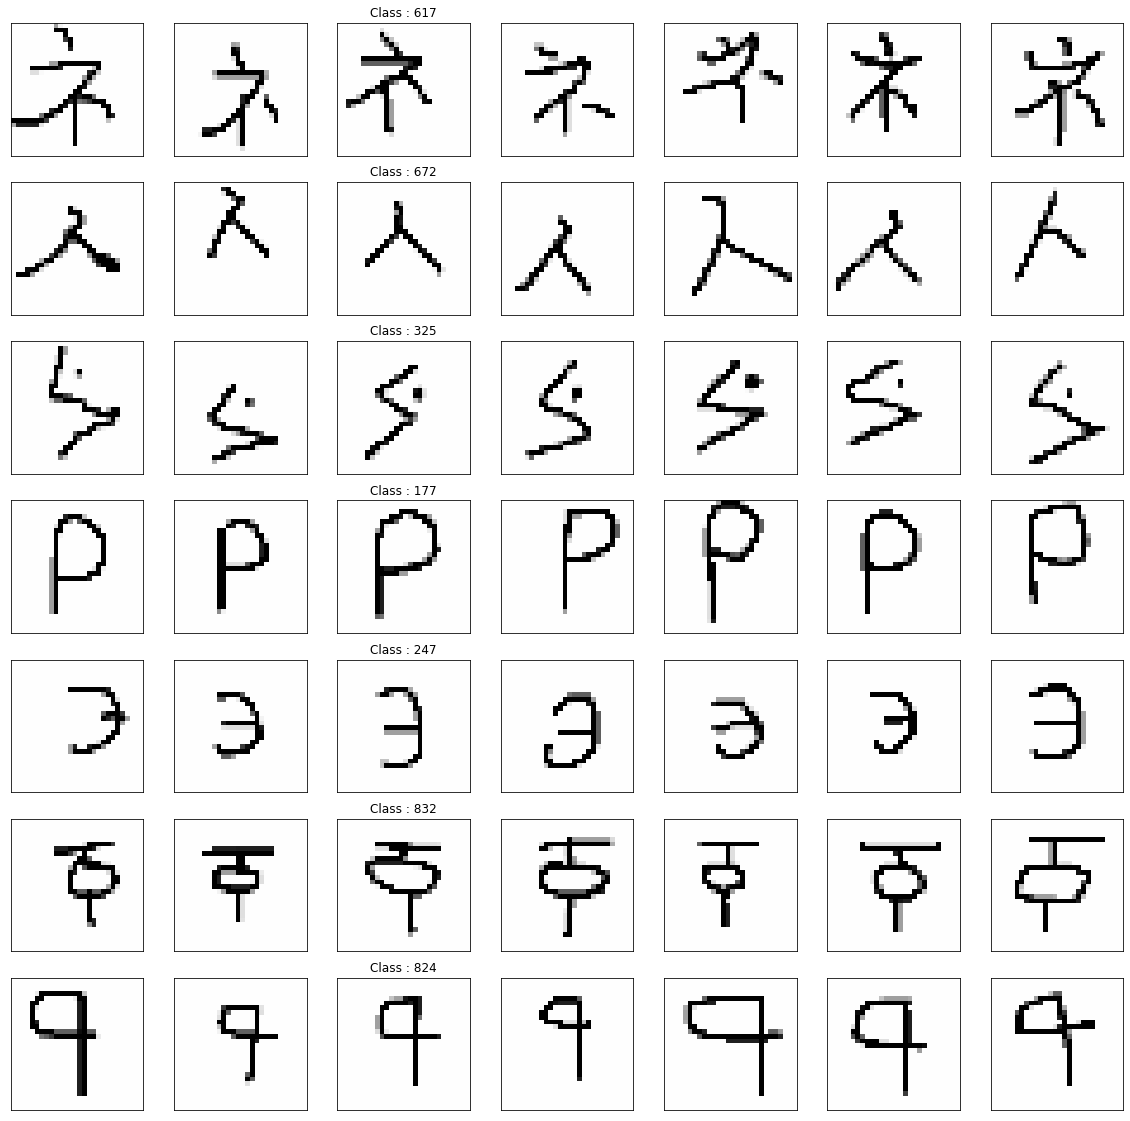

In [5]:
_, axarr = plt.subplots(nrows=7, ncols=7, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(7):
    for b in range(7):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

Create the model

In [6]:
# help function to create conv. layer
def conv_bn_layer(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

In [7]:
inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn_layer(inputs)
x = conv_bn_layer(x)
x = conv_bn_layer(x)
x = conv_bn_layer(x)
x = layers.Flatten()(x)

outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

Train the model

In [8]:
training = []
testing = []

for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # save the old weights from the model
    old_vars = model.get_weights()
    # sample from the full dataset
    mini_dataset = train_dataset.get_mini_set(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # SGD for the meta step
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # reload the newly-trained weights into the model
    model.set_weights(new_vars)
    # evaluation
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset
            train_set, test_images, test_labels = dataset.get_mini_set(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # reset the weights after getting the evaluation accuracies
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch num=%d: train acc=%f; test acc=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


batch num=0: train acc=0.285714; test acc=0.571429
batch num=300: train acc=0.714286; test acc=0.857143
batch num=600: train acc=0.714286; test acc=0.857143
batch num=900: train acc=0.714286; test acc=0.714286
batch num=1200: train acc=1.000000; test acc=0.857143
batch num=1500: train acc=1.000000; test acc=0.714286
batch num=1800: train acc=0.571429; test acc=0.857143
batch num=2100: train acc=1.000000; test acc=0.857143
batch num=2400: train acc=0.428571; test acc=0.857143
batch num=2700: train acc=1.000000; test acc=1.000000


Check results

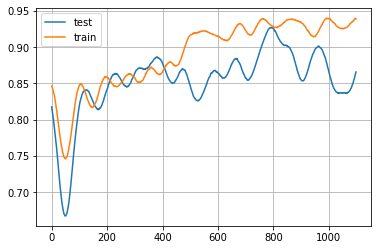

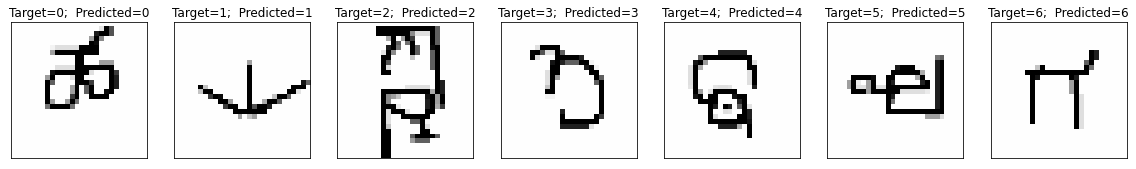

In [9]:
# preprocessing to smooth the training and testing arrays for display
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# show the training accuracies
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_set(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=7, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(7), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Target={};  Predicted={}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()
